In [40]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from tabulate import tabulate
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import chi2
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import mean_squared_error


In [41]:
# File Paths
absolute_path = "C:\\Users\\tykun\\\OneDrive\\Documents\\SchoolDocs\VSCodeProjects\\connectedData\\board_analysis\\"
altered_dataframes = "altered_dataframes\\"
gpt_dataframes = "gpt_dataframes\\"
graphs = "graphs\\"
scripts =  "scripts\\"
board_dataframes = "board_dataframes\\"
temporary = "temporary_data\\"
college_matching = "college_matching\\"

altered_dataframe_path = f"{absolute_path}{altered_dataframes}"
gpt_dataframe_path = f"{absolute_path}{gpt_dataframes}" 
graph_path = f"{absolute_path}{graphs}"
script_path = f"{absolute_path}{scripts}"
boards_path = f"{absolute_path}{board_dataframes}"
temporary_data_path = f"{absolute_path}{temporary}"
college_matching_path = f"{absolute_path}{college_matching}"


# Valid Years
years = ["1999", "2000", "2005", "2007", "2008", "2009", "2011", "2013", "2018"]

#Created Files
university_boards_statistics_path = f"{altered_dataframe_path}sample_board_statistics.csv"
university_admissions_path = f"{college_matching_path}university_admission_rate.csv"
university_demographics_path = f"{college_matching_path}university_student_demographics.csv"

In [42]:
university_board_statistics_df = pd.read_csv(university_boards_statistics_path)
university_admissions_df = pd.read_csv(university_admissions_path)
university_demographics_df = pd.read_csv(university_demographics_path)

In [43]:
def remove_non_samples(df):
    df = df[df['PrimarySample'] == True]
    return df

In [44]:
# Merge admissions data into board stats
university_board_statistics_df = university_board_statistics_df.merge(
    university_admissions_df.rename(columns={"year": "Year"}), 
    on=["Year", "AffiliationId"], 
    how="left"
)

# Merge demographics data into board stats
university_board_statistics_df = university_board_statistics_df.merge(
    university_demographics_df.rename(columns={"year": "Year"}), 
    on=["Year", "AffiliationId"], 
    how="left"
)

# print(university_board_statistics_df.head())


In [45]:
university_board_statistics_df['female_proportion'] = \
         university_board_statistics_df.apply(
             lambda row: row['female'] / row['total_members'] if row['total_members'] > 0 else 0,
             axis=1
         )

university_board_statistics_df['poc_proportion'] = \
         university_board_statistics_df.apply(
             lambda row: row['poc'] / row['total_ethnicity'] if row['total_ethnicity'] > 0 else 0,
             axis=1
         )

# Calculate the proportion of billionaires on the board
university_board_statistics_df['billionaire_proportion'] = (
    university_board_statistics_df['num_billionaires'] / 
    university_board_statistics_df['total_members'].replace(0, np.nan)
).fillna(0)

university_board_statistics_df = remove_non_samples(university_board_statistics_df)


In [46]:
# ============================
# 1. Data Preparation
# ============================



# Independent variables

#do a tenure and a turnover one
independent_vars = [
    "admissions.admission_rate.overall", 
    "student.students_with_pell_grant", 
    "female_proportion",
    "billionaire_proportion",  # Normalized proportion of billionaires
    "total_members",
    "Eigenvector",
    "student.demographics.women",
    "poc_proportion",
    "board_turnover"
]

# Dependent variable: female president (True/False)
dependent_var = "female_president"

# Time variable
year_var = "Year"

# ============================
# 2. Data Cleaning and Encoding
# ============================

# -- 1. Drop rows with missing data
regression_data = university_board_statistics_df.dropna(
    subset=[dependent_var] + independent_vars + [year_var]
).copy()

# -- 1.a. Check unique years after dropping missing data
unique_years = regression_data['Year'].unique()
print(f"Unique years in the data after dropping missing values: {unique_years}")
print(f"Number of unique years: {len(unique_years)}")

# -- 2. Ensure the dependent variable is numeric (0/1)
regression_data[dependent_var] = regression_data[dependent_var].astype(int)

# -- 3. Create dummy variables for the Year (NOT for Institution)
regression_data = pd.get_dummies(
    regression_data,
    columns=[year_var],
    drop_first=True
)

# -- 3.a. Convert Year dummy variables from bool to int (if necessary)
year_dummies = [col for col in regression_data.columns if col.startswith(f"{year_var}_")]
# Some versions of pandas might create dummy variables as int, but ensure they are
regression_data[year_dummies] = regression_data[year_dummies].astype(int)

# -- 3.b. Verify number of year dummies
print(f"Number of year dummy variables: {len(year_dummies)}")
print(f"Year dummy variables: {year_dummies}")

# -- 4. Define predictors and outcome
all_predictors = independent_vars + year_dummies

X = regression_data[all_predictors]
y = regression_data[dependent_var]

# ============================
# 3. Standardization
# ============================

# -- 5. Identify continuous variables to scale (exclude year dummies)
continuous_vars = [
    "admissions.admission_rate.overall", 
    "student.students_with_pell_grant", 
    "female_proportion",
    "billionaire_proportion",  
    "total_members",
    "Eigenvector",
    "student.demographics.women",
    "poc_proportion",
    "board_turnover"
]

# Verify that these columns exist in X
missing_vars = [var for var in continuous_vars if var not in X.columns]
if missing_vars:
    print(f"Warning: The following continuous variables are missing from X and will not be scaled: {missing_vars}")

# -- 6. Standardize the continuous independent variables
scaler = StandardScaler()
# Fit and transform only existing continuous variables
vars_to_scale = [var for var in continuous_vars if var in X.columns]
X_scaled = X.copy()
X_scaled[vars_to_scale] = scaler.fit_transform(X_scaled[vars_to_scale])

# ============================
# 4. Ensuring All Predictors are Numeric
# ============================

# -- 7. Ensure all variables are numeric
print("\nData types of predictors after scaling:")
print(X_scaled.dtypes)

# Identify non-numeric columns
non_numeric_cols = X_scaled.select_dtypes(include=['object']).columns.tolist()
if non_numeric_cols:
    print(f"\nError: The following predictor columns are not numeric and need to be converted: {non_numeric_cols}")
    # Optionally, handle them here (e.g., convert or drop)
    raise ValueError(f"Non-numeric columns detected: {non_numeric_cols}")

# ============================
# 5. Adding Intercept and Fitting the Model
# ============================

# -- 8. Add a constant term (intercept) to X
X_scaled = sm.add_constant(X_scaled)

# -- 9. Fit the logistic regression model
try:
    logit_model = sm.Logit(y, X_scaled)
    result = logit_model.fit()
except Exception as e:
    print(f"\nError fitting logistic regression model: {e}")
    raise

# -- 10. Print the summary
print("\nLogistic Regression Summary:")
print(result.summary())

# -- 11. Calculate odds ratios and p-values
odds_ratios = pd.DataFrame({
    "Variable": X_scaled.columns,
    "Coefficient": result.params,
    "Odds Ratio": np.exp(result.params),
    "P-Value": result.pvalues
})

print("\nOdds Ratios and P-Values:")
print(tabulate(odds_ratios, headers="keys", tablefmt="grid"))

# ============================
# 6. Calculating Variance Inflation Factors (VIF)
# ============================

# -- 12. Check if 'const' exists and drop it for VIF calculation
if 'const' in X_scaled.columns:
    X_check = X_scaled.drop('const', axis=1)
else:
    X_check = X_scaled.copy()

# -- 13. Calculate VIF for each predictor
vif_data = pd.DataFrame({
    "Variable": X_check.columns,
    "VIF": [variance_inflation_factor(X_check.values, i) for i in range(X_check.shape[1])]
})
print("\nVariance Inflation Factors (VIF):")
print(tabulate(vif_data, headers="keys", tablefmt="grid"))


Unique years in the data after dropping missing values: [2005 2007 2008 2009 2011 2013]
Number of unique years: 6
Number of year dummy variables: 5
Year dummy variables: ['Year_2007', 'Year_2008', 'Year_2009', 'Year_2011', 'Year_2013']

Data types of predictors after scaling:
admissions.admission_rate.overall    float64
student.students_with_pell_grant     float64
female_proportion                    float64
billionaire_proportion               float64
total_members                        float64
Eigenvector                          float64
student.demographics.women           float64
poc_proportion                       float64
board_turnover                       float64
Year_2007                              int32
Year_2008                              int32
Year_2009                              int32
Year_2011                              int32
Year_2013                              int32
dtype: object
Optimization terminated successfully.
         Current function value: 0.350865

In [47]:
# Define the treatment variable (binary indicator of high female proportion on the board)
treatment_var = "female_proportion_high"
threshold = regression_data["female_proportion"].median()  # Example threshold
regression_data[treatment_var] = (regression_data["female_proportion"] > threshold).astype(int)

# Define predictors (exclude 'female_proportion' itself to prevent data leakage)
psm_predictors = [var for var in independent_vars if var != "female_proportion"]

# Split data into train/test for checking AUC (optional)
X_psm = regression_data[psm_predictors]
y_psm = regression_data[treatment_var]
X_train, X_test, y_train, y_test = train_test_split(X_psm, y_psm, test_size=0.2, random_state=42)

# Fit logistic regression for propensity score calculation
logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)

# Predict propensity scores
regression_data["propensity_score"] = logistic_model.predict_proba(X_psm)[:, 1]

# Evaluate model with ROC AUC (optional)
auc = roc_auc_score(y_test, logistic_model.predict_proba(X_test)[:, 1])
print(f"Propensity score model AUC: {auc:.2f}")

Propensity score model AUC: 0.71


c:\Users\tykun\OneDrive\Documents\SchoolDocs\VSCodeProjects\projectEnv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [48]:
# Separate treated and control groups
treated = regression_data[regression_data[treatment_var] == 1]
control = regression_data[regression_data[treatment_var] == 0]

# Use nearest neighbor matching
nn = NearestNeighbors(n_neighbors=1)
nn.fit(control["propensity_score"].values.reshape(-1, 1))
distances, indices = nn.kneighbors(treated["propensity_score"].values.reshape(-1, 1))

# Create matched dataset
matched_control = control.iloc[indices.flatten()].reset_index(drop=True)
matched_treated = treated.reset_index(drop=True)
matched_data = pd.concat([matched_treated, matched_control], axis=0).reset_index(drop=True)

print(f"Number of matched pairs: {len(matched_treated)}")


Number of matched pairs: 507


     female_proportion  female_proportion_high  propensity_score
897           0.125000                       0          0.531622
903           0.240000                       1          0.558237
904           0.181818                       0          0.573112
908           0.200000                       0          0.498856
910           0.218750                       0          0.253203
count    1032.000000
mean        0.493938
std         0.133252
min         0.030314
25%         0.419294
50%         0.499177
75%         0.582782
max         0.923134
Name: propensity_score, dtype: float64


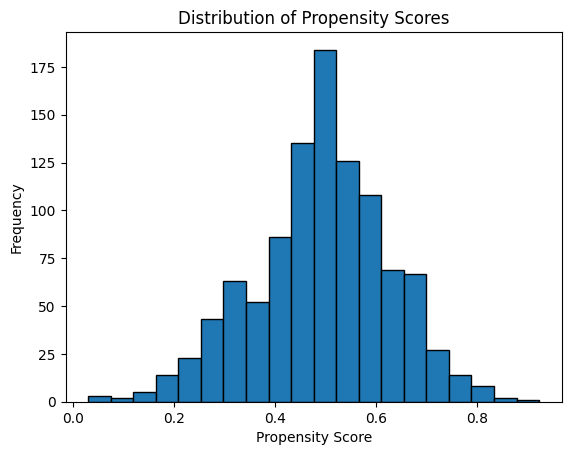

In [52]:
# Display the first few rows with propensity scores
print(regression_data[["female_proportion", treatment_var, "propensity_score"]].head())

# Summarize propensity scores
print(regression_data["propensity_score"].describe())

# Plot histogram to visualize distribution
import matplotlib.pyplot as plt

plt.hist(regression_data["propensity_score"], bins=20, edgecolor='k')
plt.xlabel("Propensity Score")
plt.ylabel("Frequency")
plt.title("Distribution of Propensity Scores")
plt.show()


In [49]:


# Calculate standardized mean difference for each covariate
def standardized_mean_difference(var):
    treated_mean = matched_treated[var].mean()
    control_mean = matched_control[var].mean()
    pooled_std = np.sqrt((matched_treated[var].var() + matched_control[var].var()) / 2)
    return (treated_mean - control_mean) / pooled_std

balance_results = {var: standardized_mean_difference(var) for var in psm_predictors}
print("Standardized Mean Differences (Post-Matching):")
for var, smd in balance_results.items():
    print(f"{var}: {smd:.2f}")


Standardized Mean Differences (Post-Matching):
admissions.admission_rate.overall: -0.02
student.students_with_pell_grant: -0.01
billionaire_proportion: 0.09
total_members: 0.10
Eigenvector: 0.04
student.demographics.women: 0.12
poc_proportion: 0.14
board_turnover: 0.01


In [54]:
import statsmodels.api as sm

# Combine matched treated and control datasets
matched_data = pd.concat([matched_treated, matched_control]).reset_index(drop=True)

# Ensure the treatment variable is included
if "female_proportion_high" not in matched_data.columns:
    raise ValueError("The treatment variable 'female_proportion_high' is not present in the matched dataset.")

# Define predictors (including the treatment variable)
outcome_var = "female_president"  # Dependent variable
predictors = ["female_proportion_high"] + [var for var in psm_predictors if var != "female_proportion"]

# Prepare data for logistic regression
X_matched = matched_data[predictors]
y_matched = matched_data[outcome_var]

# Add a constant for the intercept
X_matched = sm.add_constant(X_matched)

# Fit the logistic regression model
logit_model = sm.Logit(y_matched, X_matched)
result = logit_model.fit()

# Print the summary of the logistic regression
print("\nLogistic Regression Summary (Post-Matching):")
print(result.summary())

# Interpret coefficients for the treatment effect
odds_ratios = pd.DataFrame({
    "Variable": X_matched.columns,
    "Coefficient": result.params,
    "Odds Ratio": np.exp(result.params),
    "P-Value": result.pvalues
})

print("\nOdds Ratios and P-Values:")
print(odds_ratios)


Optimization terminated successfully.
         Current function value: 0.397298
         Iterations 7

Logistic Regression Summary (Post-Matching):
                           Logit Regression Results                           
Dep. Variable:       female_president   No. Observations:                 1014
Model:                          Logit   Df Residuals:                     1004
Method:                           MLE   Df Model:                            9
Date:                Thu, 02 Jan 2025   Pseudo R-squ.:                 0.05973
Time:                        23:18:32   Log-Likelihood:                -402.86
converged:                       True   LL-Null:                       -428.45
Covariance Type:            nonrobust   LLR p-value:                 6.437e-08
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const           